# Modèle 2D de cellules en contact

![géométrie](geometrie_master.svg)

In [1]:
import IPython.display as disp

from sympy import symbols, Matrix, Eq, Function
from sympy import sin, cos, factor
from sympy import sympify, lambdify
from sympy import diff

from sympy.physics.mechanics import dynamicsymbols, find_dynamicsymbols
from sympy.physics.mechanics import mechanics_printing
mechanics_printing(pretty_print=True) # Shinny

import numpy as np

from collections import OrderedDict
import json



In [2]:

class SymCell:
    '''
    Single cell of the cell chain. Contains the physics
    '''

    ### initial conditions (those are not arguments
    initial_names = ['F_adh_0','v_adh_0',
                     'L_x_dot_0', 'L_x_0']

    ### Static symbols (i. e. parameters)
    symbols_names = ['m_cc','eta_cc',
                     'm_cm','eta_cm', 'v_adh', 's']   
    
    ### Dynamic symbols
    #### unknown speeds
    unknowns_names = ['sigma_cc','sigma_cm', 'v_sqz', 'L_buck',
                     'L_cc','L_cm','theta']
    
    #### other time dependant variables
    dynsyms_names = ['L_x', 'L_y',
                     'G_cc','G_cm',
                     'f', 'Vol']
    
    def __init__(self):
        
        self.u_ind = [] #list of variables
        self.ud_ind = [] #list of variables derivatives
        self.arguments = [] #list of all arguments except the unknown speeds
        
        self._build_arguments()
        ### creates null_speeds dictionnaries
        self._null_subs()


    def _null_subs(self):
        ## create a dictionnary where all the speeds are replaced by 0
        self.null_speeds = {ud:0
                            for ud in self.ud_ind}

        ### second dictionnary for the other time derivatives
        self.null_other = {self.G_cc_dot: 0,
                           self.G_cm_dot: 0,
                           self.L_x_dot: 0,
                           self.L_y_dot: 0}


    def _build_arguments(self):
    
        ## This is later used to pass
        ## dynamicsymbols as arguments
        self.arg_subs = {}
        for name in self.initial_names:
            setattr(self, name, symbols(name))

        for name in self.symbols_names:
            setattr(self, name, symbols(name))
            self.arguments.append(symbols(name))
            
        for name in self.unknowns_names:
            u = dynamicsymbols(name)
            if name == 'v_sqz': ### This is allready a speed
                ##that's weird, but I don't know how else to deal with it
                self.u_ind.append(u) ## just a place holder
                self.ud_ind.append(u)
                setattr(self, name, u)
            
            else:
                self.u_ind.append(u)
                ### Dummy symbol to replace the variable when lambdifying
                q = symbols(name+'_s')
                self.arg_subs[u] = q
                self.arguments.append(q)
                setattr(self, name, u)

                ud = dynamicsymbols(name, 1)
                self.ud_ind.append(ud)
                #self.arguments.append(ud)
                setattr(self, name+'_dot', ud)

        for name in self.dynsyms_names:
            u = dynamicsymbols(name)
            q = symbols(name+'_s')
            self.arg_subs[u] = q
            self.arguments.append(q)
            setattr(self, name, u)
            
            ud = dynamicsymbols(name, 1)
            q = symbols(name+'_dot_s')
            self.arg_subs[ud] = q
            self.arguments.append(q)
            setattr(self, name+'_dot', ud)

    def build_lambdified(self):
        
        M, V = self.build()
        M_np = lambdify(self.arguments, M.subs(self.arg_subs),
                        'numpy', dummify=False)
        V_np = lambdify(self.arguments, V.subs(self.arg_subs),
                        'numpy', dummify=False)
        
        M_c, V_c = self.build_small_theta(order=3)
        M_npc = lambdify(self.arguments, M_c.subs(self.arg_subs),
                         'numpy', dummify=False)
        V_npc = lambdify(self.arguments, V_c.subs(self.arg_subs),
                         'numpy', dummify=False)
        return M_np, V_np, M_npc, V_npc
        
    def build(self, subs=None):
        """
        Generates all the equations and
        returns the  matrix M and vector V
        such that M * ud_ind = V
        
        if provided, `subs` will be used to substitute values
        in the equations
        """
        self.build_equations(subs)
        M = self.eoms.jacobian(self.ud_ind)
        V = - self.eoms.subs(self.null_speeds)
        return M, V
        
        
    def build_small_theta(self, order=1):
        if order == 1:
            small_theta = {sin(self.theta/2): self.theta/2,
                           sin(self.theta): self.theta,
                           cos(self.theta/2): 1,
                           cos(self.theta): 1}
        elif order > 1:
            small_theta = {sin(self.theta/2): self.theta/2 - (self.theta/2)**3 / 6,
                           sin(self.theta): self.theta - self.theta**3/6,
                           cos(self.theta/2): 1 - (self.theta/2)**2 / 2, # + (cell.theta/2)**4 / 24,
                           cos(self.theta): 1 - self.theta**2 / 2}
            
        M_c, V_c = self.build(small_theta)
        M_c = factor(M_c, self.theta)
        V_c = factor(V_c, self.theta)
        
        return M_c, V_c
    
        
    def build_equations(self, subs=None):
        
        self.constrains()
        self.rheology()
        self.height_and_force()
        self.rollin_n_bucklin()
        self.eoms = Matrix([diff(self.eq_Plateau),
                            diff(self.eq_longx),
                            diff(self.eq_volume),
                            self.eq_rheocc,
                            self.eq_rheocm,
                            self.eq_thetadot_rolling,
                            self.eq_thetadot_buckling])
        if subs is not None:
            self.eoms = self.eoms.subs(subs)
        
    ### System's equations
    def constrains(self):
        
        self.eq_Plateau = (- self.sigma_cc +
                             self.sigma_cm * sin(self.theta/2))
        self.eq_longx =  (- self.L_x +
                           self.L_cm * sin(self.theta/2) / (self.theta/2))
        self.eq_volume = (- self.Vol +
                          (self.L_cc - self.L_buck) * self.L_x + self.L_cm**2 * 
                          (self.theta - sin(self.theta)) / self.theta**2)                

    def rheology(self):
        
        self.eq_rheocc = (- self.L_cc_dot +
                            self.L_cc * (self.sigma_cc_dot / self.G_cc
                                         + (1 / self.eta_cc - self.G_cc_dot/self.G_cc**2
                                         ) * self.sigma_cc - self.m_cc)
                            + 2 * self.v_adh + 2 * self.v_sqz)
        
        self.eq_rheocm = (- self.L_cm_dot +
                            self.L_cm * (self.sigma_cm_dot / self.G_cm
                                         + (1 / self.eta_cm - self.G_cm_dot/self.G_cc**2
                                            ) * self.sigma_cm - self.m_cm)
                            - 2 * self.v_adh - 2 * self.v_sqz)          
    
    def height_and_force(self):
        
        self.eq_longy = (- self.L_y +
                           self.L_cc + 2 * self.L_cm * (1 - cos(self.theta/2))/self.theta)
        self.eq_force = (- self.f +
                           self.sigma_cm * (2 * cos(self.theta / 2)
                                            - self.theta * self.L_cc / self.L_cm))

    def rollin_n_bucklin(self):
        
        s = symcell.s
        self.eq_thetadot_rolling = (self.theta_dot * (s - 1) * s / 2
                                    + self.v_sqz * (1 + s) * (2 - s) / 2)
        self.eq_thetadot_buckling = (self.theta_dot * (s + 1) * s / 2
                                     + self.L_buck_dot * (1 - s) * (2 + s) / 2)



        

In [3]:
symcell = SymCell()

The unknown speeds are stored in the `u_ind` attribute

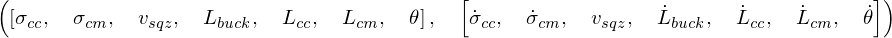

In [4]:
symcell.u_ind, symcell.ud_ind

In [5]:
symcell.arguments

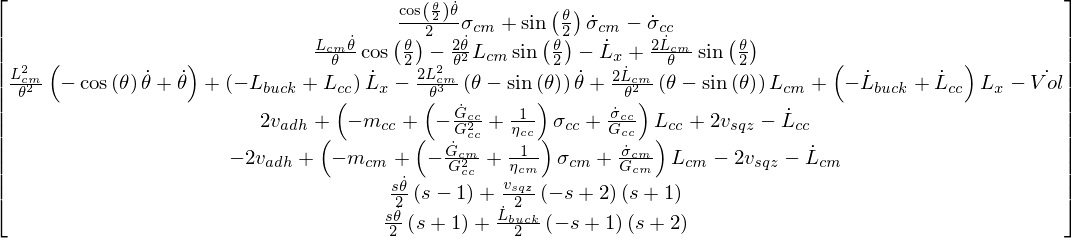

In [6]:
M, V = symcell.build()
symcell.eoms

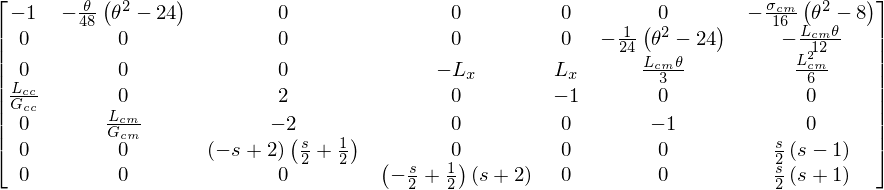

In [7]:
### Matrices for small values of theta
M_c, V_c = symcell.build_small_theta(order=3)
M_c

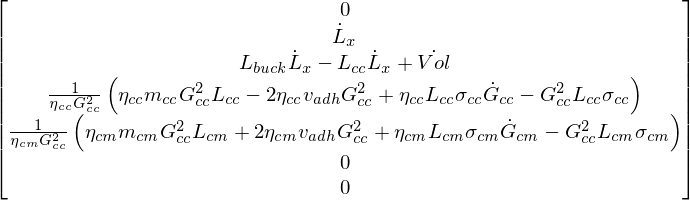

In [8]:
V_c

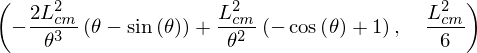

In [9]:
## Quick check
# M[2,6] = L_cm**2. * (2.*np.sin(theta) -np.cos(theta)*theta -theta) / theta**3.
M[2, 6], M_c[2, 6]

In [10]:
mechanics_printing(pretty_print=False)

In [11]:


theta_c = 1e-8 ## critical angle to avoid zero divisions

class NumCell:
    
    def __init__(self, symcell, parameters):
               
        self.parameters = parameters
        self.symcell = symcell
        self.speeds = np.zeros(len(symcell.ud_ind), dtype=np.float)
        self.variables = [str(u)[:-3] for u in symcell.u_ind]
        self.speed_index = {var: n for n, var in enumerate(self.variables)}
        self.args = OrderedDict() ### Arguments
        for arg in symcell.arguments:
            arg_name = str(arg)
            if arg_name.endswith('_s'):
                ### Fall back to the original name
                param_name = arg_name[:-2]
            else:
                param_name = arg_name
            initial = parameters.get(param_name)
            #if initial is not None:
            #    setattr(self, param_name, initial)
            #else:
            #    setattr(self, param_name, 0)
            self.args[param_name] = 0 if initial is None else initial#getattr(self, param_name)
        
        self.build_matrices()
        self.step_elapsed = 0
        self.time = 0.
        self.update_diff()
        
    def get_speed(self, var):
        return self.speeds[self.speed_index[var]]
        
    def build_matrices(self):
        
        self.M, self.V, self.M_c, self.V_c = self.symcell.build_lambdified()
        
    @property ## see this for details: https://docs.python.org/3.4/library/functions.html#property
    def force(self):

        sigma_cm = self.parameters['sigma_cm']
        L_cc = self.parameters['L_cc']
        L_cm = self.parameters['L_cm']
        theta = self.parameters['theta']
        
        return sigma_cm * (2.0 * np.cos(theta/2.0) - theta * L_cc/L_cm)
    
    @property
    def volume(self):
        
        L_cc = self.parameters['L_cc']
        L_cm = self.parameters['L_cm']
        L_x = self.parameters['L_x']
        L_buck = self.parameters['L_buck']
        theta = self.parameters['theta']
        if theta < theta_c:
            vol = (L_cc - L_buck) * self.L_x
        else:
            vol = ((L_cc - L_buck) * L_x
                   + L_cm**2 * (theta - np.sin(theta)) / theta**2)
        return vol

    def step(self, dt):
        
        self.step_elapsed += 1
        self.time += dt
        self.increment(dt)
        self.condition_s()
        self.update_diff()
        
    def update_diff(self):
        '''
        Solves the differentials through linear inversion
        '''
        self.parameters['theta']
        self.prev_v_sqz = self.get_speed('v_sqz')
        M = self.M(*self.args.values())
        V = self.V(*self.args.values())
        self.determ = np.linalg.det(M)
        self.speeds = np.linalg.solve(M, V)
    
    def increment(self, dt):
        
        for n, var in enumerate(self.variables):
            if var == 'v_sqz':
                continue
                # numcell.parameters[var] = speeds[n]
            else:
                numcell.parameters[var] += self.speeds[n] * dt
    
    def condition_s(self):
        
        theta = self.parameters['theta']
        theta_dot = self.get_speed('theta')
        L_buck = self.parameters['L_buck']
        L_buck_dot = self.get_speed('L_buck')
        v_sqz = self.get_speed('v_sqz')
        prev_v_sqz = self.prev_v_sqz
        s = self.parameters['s']
        test = 0
        
        if (s == 0) & (test == 0) :
            L_buck = 0.0
            
            if (theta >= np.pi) & (theta_dot > 0.0) :
                s = -1
                # backtime is supposed to be positive
                backtime = (theta - np.pi) / theta_dot
                self.increment(-backtime)
                theta = np.pi
                test = 1

            elif (theta <= 0.0) & (theta_dot < 0.0) :
                s = 1
                # backtime is supposed to be positive
                backtime = theta / theta_dot
                self.increment(-backtime)
                theta = 0.0
                test = 1
                
        if (s == 1) & (test == 0) :
            theta = 0.0
            if (L_buck <= 0.0) & (L_buck_dot < 0.0) :
                s = 0
                # backtime is supposed to be positive
                backtime = L_buck / L_buck_dot
                self.increment(-backtime)
                test = 1
        
        if (s == -1) & (test == 0) :
            L_buck = 0.0
            theta = np.pi
            if v_sqz < 0.0:
                s = 0
                # backtime is supposed to be positive
                backtime = v_sqz / (v_sqz - prev_v_sqz) ### * self.dt uh?
                self.increment(-backtime)
                test = 1
        self.parameters['s'] = s
    
### As this is an external stimulation, it seems logical 
### to define it outside of the class definition
def L_x_dot_function(numcell, freq, amplitude, times) :
    
    L_x_dot = numcell.parameters['L_x_dot']
    L_x = numcell.parameters['L_x']
    G_cc = numcell.parameters['G_cc']
    m_cc = numcell.parameters['m_cc']
    eta_cc = numcell.parameters['eta_cc']
    v_adh = numcell.parameters['v_adh']
    amplitude = - min(1./10. * min(G_cc/eta_cc,
                                   min(m_cc, v_adh/L_x))/freq,
                        L_x/5) * 2. * np.pi * freq

    L_x_dots =  amplitude * np.sin(2*np.pi * freq * times)
    return L_x_dots

    

In [12]:
parameters = {'L_x':  1.,
              'L_x_dot': 0.,
              'v_adh': 0.02,
              'F_adh': 0.06,
              'm_cc': 0.1,
              'eta_cc': 0.5,
              'G_cc_dot': 0., 
              'm_cm': 0.1,
              'eta_cm': 0.5,
              'G_cm_dot': 0.,
              'V_dot': 0.,
              'sigma_cc':  0.0378112500962,
              'sigma_cm':  0.0557574320458,
              'v_sqz':  0.,
              'L_buck':  0.,
              'L_cc':  0.51832867931,
              'L_cm':  1.09732599832,
              'theta':  1.48682076362,
              'G_cc':  1.,
              'G_cm':  1.,
              's':  0,
              'thetime':  0.,
              'v_adh': 0.00631778245004,
              'force':  0.0429343631124}

init_parameters = OrderedDict(parameters)
with open('params_20150320.json', 'w+') as p_file:
    parmafile = json.dump(init_parameters, p_file)


In [13]:
import pandas as pd

dt = 1e-1
time_sim = 50
#freq = 1e1
freq = 0
if freq != 0 : 
    dt = min(1. / (500 * freq), 9e-1)
    time_sim=50 + 5./freq
    print('time step: {}'.format(dt))

tol= 1e-2 ## Tolerance for the determinent
plot = True


times = np.arange(0, time_sim, dt)
n_steps = times.size

CSI   = "\x1B["
reset = CSI+"m"  

color_str = lambda X: CSI+"34;49m"+str(X)+reset
info_str = map(color_str, (n_steps, round(time_sim, 2)))

print('Max. number of steps : %s (sim. time : %ss)' % tuple(info_str))

                  
numcell = NumCell(symcell, init_parameters)

data = pd.DataFrame(np.zeros((n_steps, len(numcell.parameters))),
                             columns=numcell.parameters.keys(),
                             index=pd.Index(times))

if freq != 0:
    L_x_dots =  L_x_dot_function(numcell, freq, times)

# Exit mode - 0=normal, 1=problem with Lenghts, 2=problem with determinant
exit = 0

    
for n, t in enumerate(times):
    if freq != 0:
        numcell.parameters['L_x_dot'] = L_x_dots[n]
    
    numcell.step(dt)
    L_cc = numcell.parameters['L_cc']
    L_cm = numcell.parameters['L_cm']   
    
    ## register the data
    for name, val in numcell.parameters.items():
        data.loc[t, name] = val

    if L_cc < 0. or L_cm <= 0. :
            n_steps = syst.steps_elapsed
            exit = 1
            break          
    elif abs(numcell.determ) < tol :
            n_steps = syst.steps_elapsed
            exit = 2
            break
    
print(exit)

Max. number of steps : 500 (sim. time : 50s)
0


In [14]:
data[numcell.variables].head()

,sigma_cc,sigma_cm,v_sqz,L_buck,L_cc,L_cm,theta
0.0,0.037811,0.055757,0,0,0.518329,1.097326,1.486821
0.1,0.037811,0.055757,0,0,0.518329,1.097326,1.486821
0.2,0.037811,0.055757,0,0,0.518329,1.097326,1.486821
0.3,0.037811,0.055757,0,0,0.518329,1.097326,1.486821
0.4,0.037811,0.055757,0,0,0.518329,1.097326,1.486821


In [15]:
numcell.force, numcell.volume

(matrix([[ 0.04293445]]), matrix([[ 0.78541739]]))

In [17]:
import matplotlib.pyplot as plt
%matplotlib qt4
data.L_x.plot()

In [78]:
dict(numcell.parameters)

{'F_adh': 0.06,
 'G_cc': 1.0,
 'G_cc_dot': 0.0,
 'G_cm': 1.0,
 'G_cm_dot': 0.0,
 'L_buck': 0.0,
 'L_cc': 0.51832867931,
 'L_cm': 1.09732599832,
 'L_x': 1.0,
 'L_x_dot': 0.0,
 'V_dot': 0.0,
 'eta_cc': 0.5,
 'eta_cm': 0.5,
 'force': 0.0429343631124,
 'm_cc': 0.1,
 'm_cm': 0.1,
 's': 0,
 'sigma_cc': 0.0378112500962,
 'sigma_cm': 0.0557574320458,
 'theta': 1.48682076362,
 'thetime': 0.0,
 'v_adh': 0.00631778245004,
 'v_sqz': 0.0}

In [79]:
numcell.variables

['sigma_cc', 'sigma_cm', 'v_sqz', 'L_buck', 'L_cc', 'L_cm', 'theta']

In [80]:
numcell.M(*numcell.args.values())

matrix([[-1.        ,  0.67680245,  0.        ,  0.        ,  0.        ,
          0.        ,  0.02052333],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.9104022 , -0.12859341],
        [ 0.        ,  0.        ,  0.        , -1.        ,  1.        ,
          0.48679921,  0.13973356],
        [ 0.51832868,  0.        ,  2.        ,  0.        , -1.        ,
          0.        ,  0.        ],
        [ 0.        ,  1.097326  , -2.        ,  0.        ,  0.        ,
         -1.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
          0.        ,  0.        ]])

In [81]:
numcell.step(1)

In [82]:
numcell.M(*numcell.args.values())

matrix([[-1.        ,  0.67680245,  0.        ,  0.        ,  0.        ,
          0.        ,  0.02052333],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.9104022 , -0.12859341],
        [ 0.        ,  0.        ,  0.        , -1.        ,  1.        ,
          0.48679921,  0.13973356],
        [ 0.51832868,  0.        ,  2.        ,  0.        , -1.        ,
          0.        ,  0.        ],
        [ 0.        ,  1.097326  , -2.        ,  0.        ,  0.        ,
         -1.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
          0.        ,  0.        ]])

In [83]:
numcell.speeds


matrix([[ -5.90297486e-10],
        [  1.91579664e-10],
        [  6.26798330e-25],
        [ -0.00000000e+00],
        [  7.31395879e-09],
        [ -4.95502057e-09],
        [ -3.50800381e-08]])